In [2]:
import numpy as np
import pandas as pd
import xlwt

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
def create_exel_file(file_name, data, forecast):
    def get_style(colour):
        style = xlwt.XFStyle()
        pattern = xlwt.Pattern()
        pattern.pattern = xlwt.Pattern.SOLID_PATTERN
        pattern.pattern_fore_colour = xlwt.Style.colour_map[colour]
        style.pattern = pattern

        return style

    book = xlwt.Workbook()
    writeSheet = book.add_sheet(file_name)

    xlwt.add_palette_colour("metrics", 0x21)
    book.set_colour_RGB(0x21, 112, 238, 233)

    xlwt.add_palette_colour("menu", 0x22)
    book.set_colour_RGB(0x22, 56, 247, 43)

    menu_style = get_style('menu')
    metrics_style = get_style('metrics')

    assert len(forecast) == len(data), "Not equals length!"

    writeSheet.write(0, 0, 'Real', menu_style)
    writeSheet.write(0, 1, 'Forecast', menu_style)
    writeSheet.write(0, 2, 'R - F', menu_style)
    writeSheet.write(0, 3, '(R - F)^2', menu_style)
    
    writeSheet.write(0, 4, 'MSE', menu_style)
    writeSheet.write(0, 5, 'MAE', menu_style)

    for i in range(len(forecast)):
        writeSheet.write(i + 1, 0, (data[i]))
        writeSheet.write(i + 1, 1, (forecast[i]))
        writeSheet.write(i + 1, 2, (data[i] - forecast[i]))
        writeSheet.write(i + 1, 3, ((data[i] - forecast[i])**2))

    writeSheet.write(1, 4, mean_squared_error(data, forecast), metrics_style)
    writeSheet.write(1, 5, mean_absolute_error(data, forecast), metrics_style)

    book.save('{}.xls'.format(file_name))

In [4]:
df = pd.read_csv('logs/covid_daily.csv')

df_deceased = df.loc[df['Случай'] == 'Умерло']

data = np.array(df_deceased.loc[df_deceased['Регион'] == 'Москва'].iloc[0][2:], dtype=np.float64)
diff_data = data[:-14]
diff_data = np.diff(diff_data)

In [5]:
import statsmodels.api as sm
test = sm.tsa.adfuller(diff_data)

if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

единичных корней нет, ряд стационарен


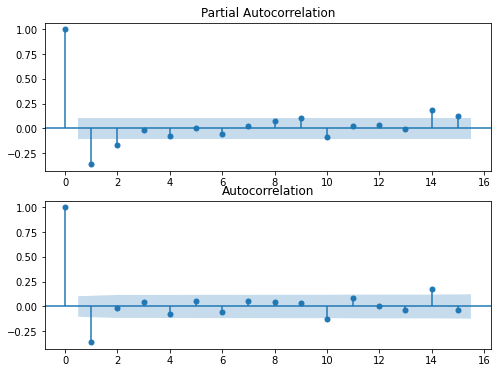

In [6]:
fig = plt.figure(figsize=(8,6))
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(diff_data, lags=15, ax=ax2)
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_acf(diff_data.squeeze(), lags=15, ax=ax1)

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data[:-14], order=(1, 1, 2))
model_fit = model.fit()
res = model_fit.predict(len(data[:-14]), len(data) - 1)

create_exel_file('forecast', data[-14:], res)

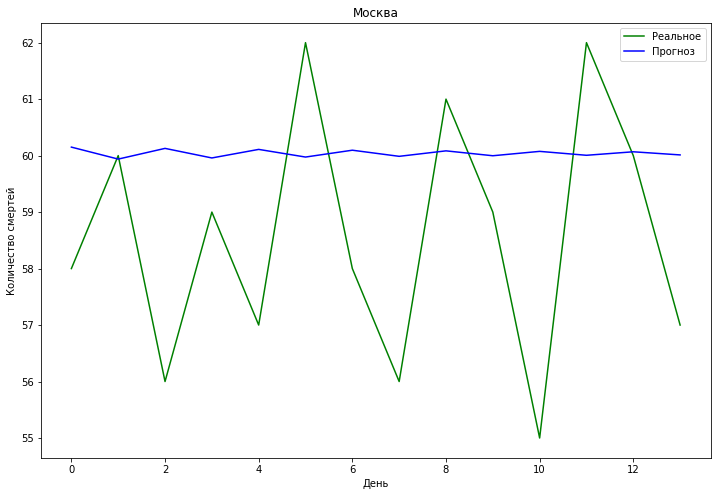

In [14]:
plt.figure(figsize=(12,8))

plt.plot(data[-20:-6], 'g', label='Реальное')
plt.plot(res, 'b', label='Прогноз')

plt.legend()

plt.title('Москва')
plt.xlabel('День')
plt.ylabel('Количество смертей')
plt.show()